In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
import os
import random
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/vww.zip

to check the balance of dataset and total number of samples

In [ ]:
data_dir = 'vww/'

print("Number of samples")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print(f, " : ", len(os.listdir(data_dir + '/' + f +'/')))

Number of samples
person  :  300
notperson  :  300


Split into training and validation into 80:20 ratio

In [ ]:
batch_size = 64

print("Training data")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,image_size=(96, 96),validation_split=0.2,subset="training",seed=113, batch_size=batch_size)

print("Validation data")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,image_size=(96, 96),validation_split=0.2,subset="validation",seed=113, batch_size=batch_size)

Training data
Found 600 files belonging to 2 classes.
Using 480 files for training.
Validation data
Found 600 files belonging to 2 classes.
Using 120 files for validation.


Defining class names

In [ ]:
class_names = train_ds.class_names
print(class_names)

['notperson', 'person']


###Visualization

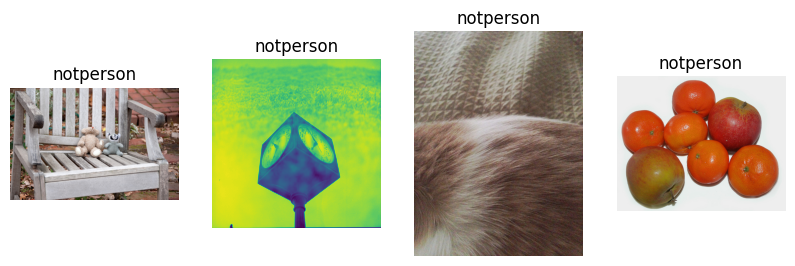

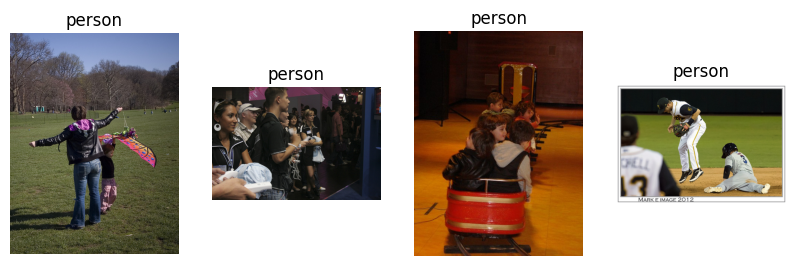

In [ ]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(data_dir + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(data_dir + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

###Preprocessing

Input shape definition

In [ ]:
print("Shape of one training data")
for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Input: ", image_batch.shape)
    print("Labels: ", labels_batch.shape)
    break

Shape of one training data
Input:  (64, 96, 96, 3)
Labels:  (64,)


Normalizing the pixel values - Pixel values have been transformed into integers with an interval of 0 to 255. The range [0, 1] should be used to make them for quicker convergence.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Model Training

##Transfer learning

Number of neurons as number of class and single dense layer is used

In [ ]:
base_model_training = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    
base_model_training.trainable = False
inputs = tf.keras.Input(shape=input_shape)
x = base_model_training(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation = 'sigmoid')(x)   
model = tf.keras.Model(inputs, outputs)
cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_22  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])
history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)

Epoch 1/32
8/8 [==============================] - 13s 1s/step - loss: 0.8163 - accuracy: 0.6854 - val_loss: 0.6427 - val_accuracy: 0.7833
Epoch 2/32
8/8 [==============================] - 6s 543ms/step - loss: 0.3605 - accuracy: 0.8875 - val_loss: 0.4614 - val_accuracy: 0.9083
Epoch 3/32
8/8 [==============================] - 6s 543ms/step - loss: 0.1773 - accuracy: 0.9375 - val_loss: 0.4378 - val_accuracy: 0.8833
Epoch 4/32
8/8 [==============================] - 8s 635ms/step - loss: 0.1077 - accuracy: 0.9604 - val_loss: 0.4886 - val_accuracy: 0.8500
Epoch 5/32
8/8 [==============================] - 14s 2s/step - loss: 0.0431 - accuracy: 0.9833 - val_loss: 0.5131 - val_accuracy: 0.8750
Epoch 6/32
8/8 [==============================] - 9s 1s/step - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.4899 - val_accuracy: 0.8583
Epoch 7/32
8/8 [==============================] - 6s 575ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.5012 - val_accuracy: 0.8750
Epoch 8/32
8/8 [===========

In [ ]:
print("Training data results:")
print(model.evaluate(train_ds))
print("Validation data results:")
model.evaluate(val_ds)

Training data results:
8/8 [==============================] - 7s 406ms/step - loss: 0.0805 - accuracy: 0.9750
[0.08046039938926697, 0.9750000238418579]
Validation data results:
2/2 [==============================] - 1s 343ms/step - loss: 0.4378 - accuracy: 0.8833


[0.43781211972236633, 0.8833333253860474]

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Result Visualization for choosen model

In [ ]:
def plot(history, variable, variable2,Work):
    plt.plot(range(len(history[variable])), history[variable],color = 'Blue',label='Training'+ Work)
    plt.plot(range(len(history[variable2])), history[variable2],color = 'red',label='Validation'+ Work)
    plt.title(variable)

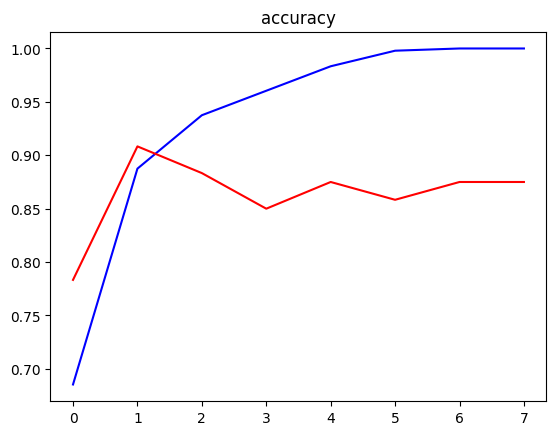

In [ ]:
plot(history.history, "accuracy", 'val_accuracy',"Accuracy")

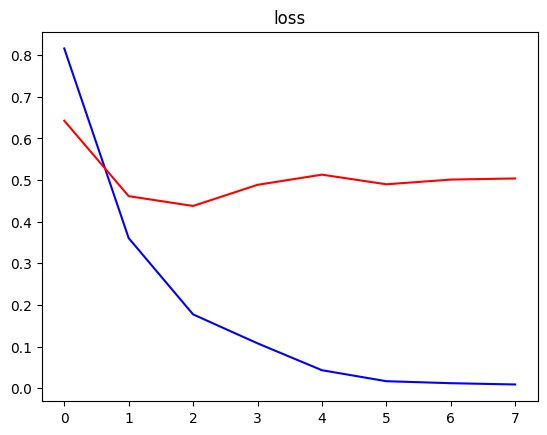

In [ ]:
plot(history.history, "loss", "val_loss","Loss")

###Prediction

1/1 [==============================] - 1s 946ms/step
Probability:  0.9999231
Predicted class:  notperson
True class:  notperson


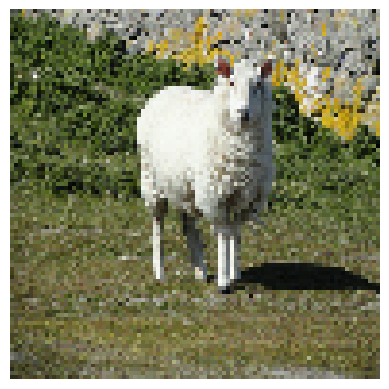

In [ ]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Probability: ", output[0][pred])
    print("Predicted class: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True class: ", class_names[label[x]])
    
    break

# Model Robustness Checking

###1

change number of neurons in the original neural network

In [ ]:
no_of_neurons_1 = len(class_names)
no_of_neurons_2 = 10*len(class_names)
train_accuracy=[]
val_accuracy=[]
i=1
neurons=[]
while(i*no_of_neurons_1<no_of_neurons_2):
  neurons.append(i*no_of_neurons_1)
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model

  base_model.trainable = False

  inputs = tf.keras.Input(shape=input_shape)

  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax')(x)    # Add own classififcation layer

  model = tf.keras.Model(inputs, outputs)

  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])

  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])
  i+=1
  #model.summary()

In [ ]:
pd.DataFrame({'No. of neurons':neurons,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,No. of neurons,Train Accuracy,Validation Accuracy
0,2,0.904167,0.908333
1,4,0.979167,0.883333
2,6,0.937500,0.891667
3,8,0.902083,0.866667
4,10,0.897917,0.866667
5,12,1.000000,0.875000
6,14,0.893750,0.908333
7,16,0.895833,0.875000
8,18,0.931250,0.891667


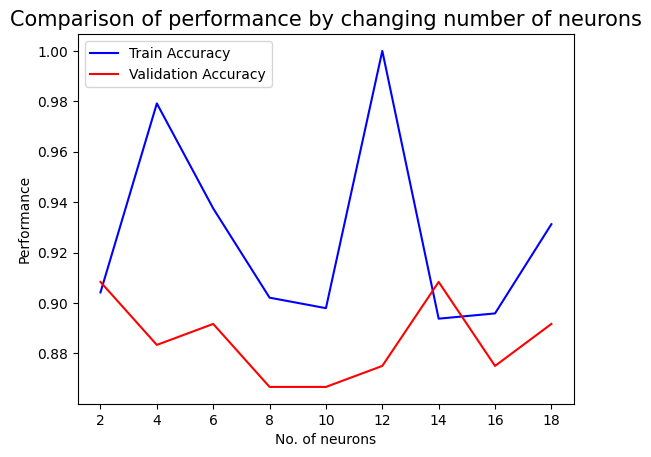

In [ ]:
plt.plot(neurons,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(neurons,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("No. of neurons")
plt.title('Comparison of performance by changing number of neurons', size=15)
plt.legend()
plt.show()

###2

Changing Activation function - The choice of activation function can also affect the robustness of a neural network. Some activation functions, such as ReLU, can cause neurons to "die" if their input falls below zero, which can make the network less robust to changes in the input. Other activation functions, such as LeakyReLU or ELU, can help mitigate this problem.

In [ ]:
no_of_neurons_1 = len(class_names)
activation=['softmax','ReLU','sigmoid','tanh']
train_accuracy=[]
val_accuracy=[]
for i in activation:
  neurons.append(i)
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = i)(x)    # Add own classification layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

In [ ]:
pd.DataFrame({'Activation':activation,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Activation,Train Accuracy,Validation Accuracy
0,softmax,0.979167,0.875000
1,ReLU,0.500000,0.500000
2,sigmoid,1.000000,0.883333
3,tanh,0.827083,0.816667


###3

Change dropout rate - Dropout is a regularization technique used to prevent overfitting in neural networks. By randomly dropping out nodes during training, the network becomes less sensitive to the specific weights of any individual node. You can adjust the dropout rate to increase or decrease the amount of dropout regularization applied to the network.

In [ ]:
no_of_neurons_1 = len(class_names)
dropout_rate=[0.001,0.004,0.008,0.02,0.05,0.1,0.2,0.3]
train_accuracy=[]
val_accuracy=[]
for i in dropout_rate:
  neurons.append(i)
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax')(x)    # Add own classififcation layer
  tf.keras.layers.Dropout(i)
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

In [ ]:
pd.DataFrame({'Dropout rate':dropout_rate,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Dropout rate,Train Accuracy,Validation Accuracy
0,0.001,0.987500,0.875000
1,0.004,0.947917,0.875000
2,0.008,0.977083,0.875000
3,0.020,1.000000,0.858333
4,0.050,0.952083,0.883333
5,0.100,0.889583,0.866667
6,0.200,0.929167,0.866667
7,0.300,0.875000,0.875000


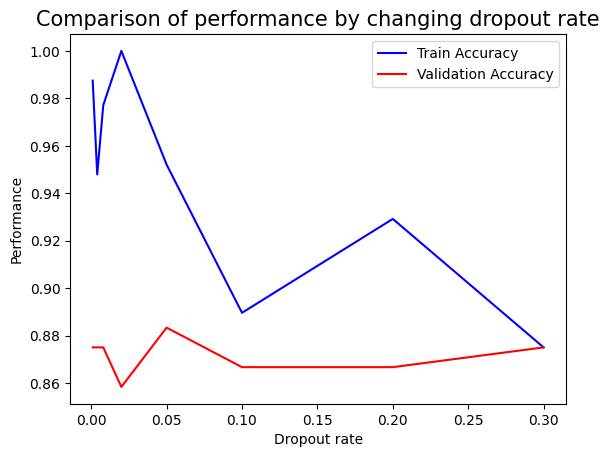

In [ ]:
plt.plot(dropout_rate,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(dropout_rate,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Dropout rate")
plt.title('Comparison of performance by changing dropout rate', size=15)
plt.legend()
plt.show()

###4

Apply and change Weight regularization and observe changes on accuracy

In [ ]:

from tensorflow.keras import regularizers
no_of_neurons_1 = len(class_names)
regularization_params = [0.001, 0.01, 0.1, 1]
train_accuracy=[]
val_accuracy=[]
for param in regularization_params:
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax', kernel_regularizer=regularizers.l2(param))(x)    # Add own classififcation layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

In [ ]:
pd.DataFrame({'Kernel weight regularization parameter':regularization_params,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Kernel weight regularization parameter,Train Accuracy,Validation Accuracy
0,0.001,0.939583,0.900000
1,0.010,1.000000,0.866667
2,0.100,0.997917,0.883333
3,1.000,0.950000,0.900000


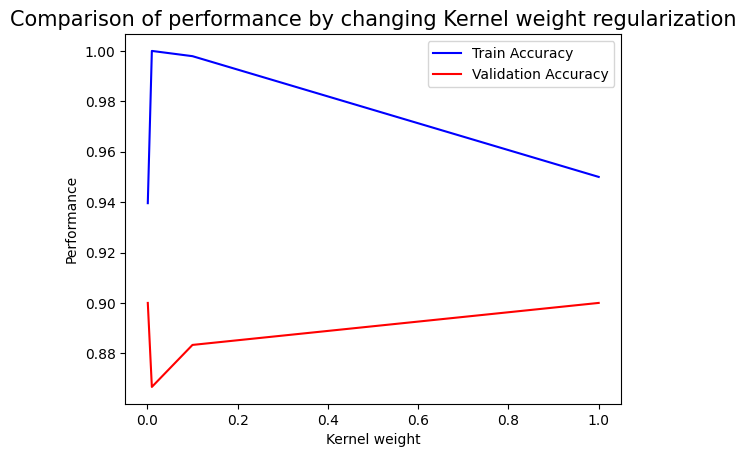

In [ ]:
plt.plot(regularization_params,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(regularization_params,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Kernel weight")
plt.title('Comparison of performance by changing Kernel weight regularization', size=15)
plt.legend()
plt.show()

###5

Change batch size - Batch size refers to the number of samples that will be used in one training iteration. In other words, it's the number of training examples that the model will see before updating the weights of the neural network.

In [ ]:
from tensorflow.keras import regularizers
no_of_neurons_1 = len(class_names)
batch_Size = [16,32,64,128,256,512]
train_accuracy=[]
val_accuracy=[]
for batch in batch_Size:
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax')(x)    # Add own classififcation layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb,batch_size=batch)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

In [ ]:
pd.DataFrame({'Batch Size':batch_Size,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Batch Size,Train Accuracy,Validation Accuracy
0,16,0.908333,0.850000
1,32,1.000000,0.866667
2,64,0.933333,0.833333
3,128,0.975000,0.900000
4,256,0.912500,0.850000
5,512,0.966667,0.900000


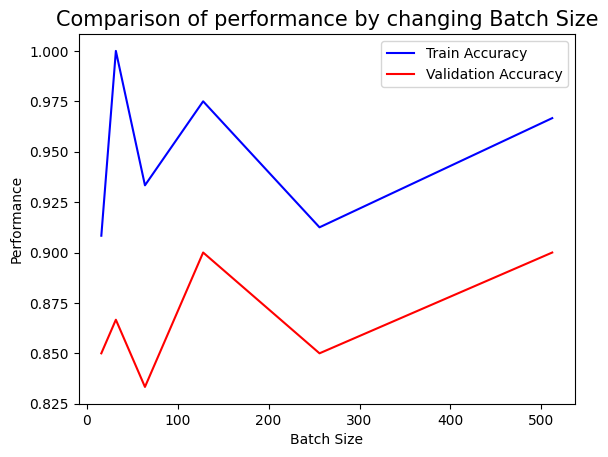

In [ ]:
plt.plot(batch_Size,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(batch_Size,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Batch Size")
plt.title('Comparison of performance by changing Batch Size', size=15)
plt.legend()
plt.show()

#6

###Learning Rate

In [ ]:
learning_rates = [0.001,0.005, 0.01,0.05, 0.1,0.5, 1]
train_accuracy=[]
val_accuracy=[]
for lr in learning_rates:
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax')(x)   
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

8/8 [==============================] - 6s 565ms/step - loss: 20.5893 - accuracy: 0.9104 - val_loss: 38.0503 - val_accuracy: 0.8333
Epoch 4/32
8/8 [==============================] - 6s 548ms/step - loss: 9.7983 - accuracy: 0.9563 - val_loss: 35.4274 - val_accuracy: 0.9250
Epoch 5/32
8/8 [==============================] - 8s 674ms/step - loss: 3.6380 - accuracy: 0.9708 - val_loss: 30.8178 - val_accuracy: 0.8750
Epoch 6/32
8/8 [==============================] - 7s 729ms/step - loss: 1.4177 - accuracy: 0.9833 - val_loss: 32.7676 - val_accuracy: 0.8833
Epoch 7/32
8/8 [==============================] - 9s 737ms/step - loss: 0.4174 - accuracy: 0.9896 - val_loss: 33.5051 - val_accuracy: 0.8750
Epoch 8/32
8/8 [==============================] - 7s 801ms/step - loss: 0.1476 - accuracy: 0.9958 - val_loss: 34.5426 - val_accuracy: 0.8917
Epoch 9/32
8/8 [==============================] - 6s 530ms/step - loss: 0.0031 - accuracy: 0.9979 - val_loss: 35.1030 - val_accuracy: 0.8917
Epoch 10/32
8/8 [======

In [ ]:
pd.DataFrame({'Learning Rate':learning_rates,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Learning Rate,Train Accuracy,Validation Accuracy
0,0.001,0.985417,0.858333
1,0.005,0.952083,0.916667
2,0.010,0.977083,0.900000
3,0.050,0.908333,0.883333
4,0.100,0.904167,0.875000
5,0.500,0.927083,0.858333
6,1.000,0.979167,0.875000


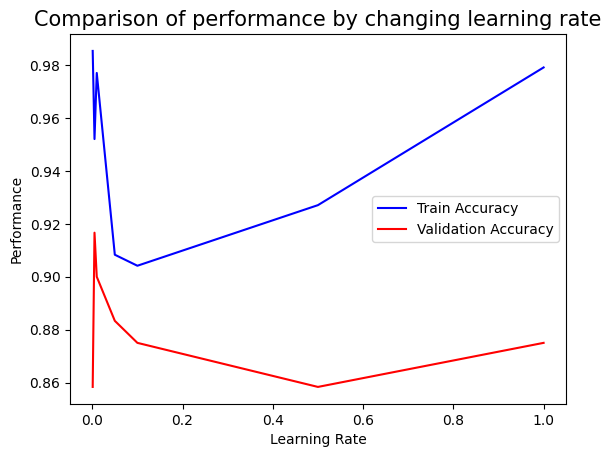

In [ ]:
plt.plot(learning_rates,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(learning_rates,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Learning Rate")
plt.title('Comparison of performance by changing learning rate', size=15)
plt.legend()
plt.show()

# Reduce Neural Network Size in terms of different parameters

###1

Change number of neurons - The width multiplier, controls the number of neurons per layer by scaling the number of channels in each layer. A smaller width multiplier reduces the number of neurons and the number of parameters in the network, while a larger width multiplier increases the number of neurons and the number of parameters. Similar to the depth multiplier, changing the width multiplier also affects the performance of the network. A smaller width multiplier reduces the computational cost and memory usage of the network, but may also reduce its accuracy.

In [ ]:
no_of_neurons_1 = 2*len(class_names)
no_of_neurons_2 = 10*len(class_names)
train_accuracy=[]
val_accuracy=[]
i=1
neurons=[]
while(i*no_of_neurons_1<no_of_neurons_2):
  neurons.append(i)
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax')(x)    # Add own classififcation layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])
  i+=1

8/8 [==============================] - 5s 377ms/step - loss: 0.1964 - accuracy: 0.9292


In [ ]:
pd.DataFrame({'No. of neurons':neurons,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,No. of neurons,Train Accuracy,Validation Accuracy
0,1,0.920833,0.891667
1,2,0.947917,0.875000
2,3,0.895833,0.850000
3,4,0.929167,0.858333


In [ ]:
len(class_names)

2

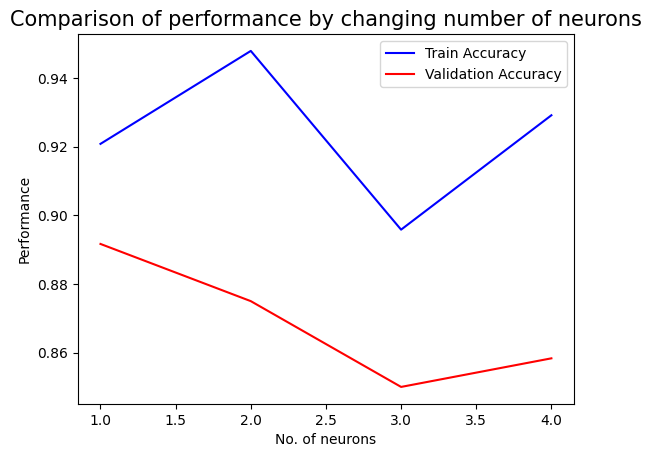

In [ ]:
plt.plot(neurons,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(neurons,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("No. of neurons")
plt.title('Comparison of performance by changing number of neurons', size=15)
plt.legend()
plt.show()

###2

Number of layers - The depth multiplier controls the number of layers in the network by reducing the number of filters in each layer. It effectively scales the depth of the network, with a smaller depth multiplier resulting in a shallower network and a larger depth multiplier resulting in a deeper network. However, changing the depth multiplier also affects the performance of the network. A smaller depth multiplier reduces the number of parameters and computational cost, but may also reduce the network's accuracy.

In [ ]:
No_of_layers=[2,3,4,5,6]
train_accuracy=[]
val_accuracy=[]

In [ ]:

for i in No_of_layers:
  neuron=64
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  for j in range(i):
    x=tf.keras.layers.Dense(neuron, activation='softmax')(x)
    neuron=neuron*2
  outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

In [ ]:
pd.DataFrame({'No. of layers':No_of_layers,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,No. of layers,Train Accuracy,Validation Accuracy
0,2,0.977083,0.883333
1,3,0.968750,0.866667
2,4,0.500000,0.500000
3,5,0.500000,0.500000
4,6,0.500000,0.500000


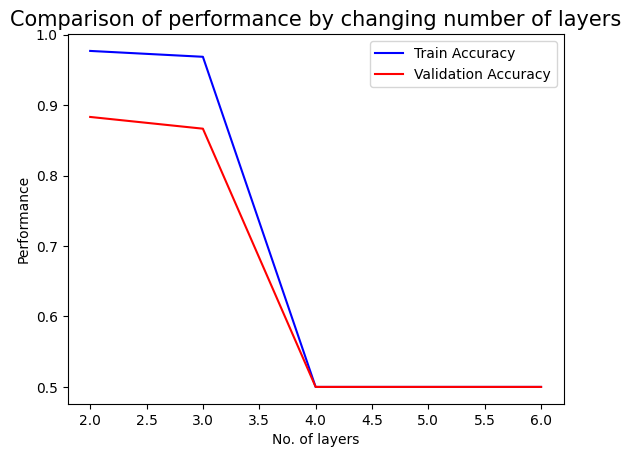

In [ ]:
plt.plot(No_of_layers,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(No_of_layers,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("No. of layers")
plt.title('Comparison of performance by changing number of layers', size=15)
plt.legend()
plt.show()

#3

Apply and change Weight regularization and observe changes on accuracy

In [ ]:

from tensorflow.keras import regularizers
no_of_neurons_1 = len(class_names)
regularization_params = [0.001, 0.01, 0.1, 1]
train_accuracy=[]
val_accuracy=[]
for param in regularization_params:
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax', kernel_regularizer=regularizers.l2(param))(x)    # Add own classififcation layer
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

8/8 [==============================] - 8s 574ms/step - loss: 0.5144 - accuracy: 0.8813 - val_loss: 0.5038 - val_accuracy: 0.8917
Epoch 12/32
8/8 [==============================] - 6s 364ms/step - loss: 0.4233 - accuracy: 0.9167


In [ ]:
pd.DataFrame({'Kernel weight regularization parameter':regularization_params,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Kernel weight regularization parameter,Train Accuracy,Validation Accuracy
0,0.001,0.997917,0.883333
1,0.010,1.000000,0.908333
2,0.100,0.997917,0.916667
3,1.000,0.916667,0.891667


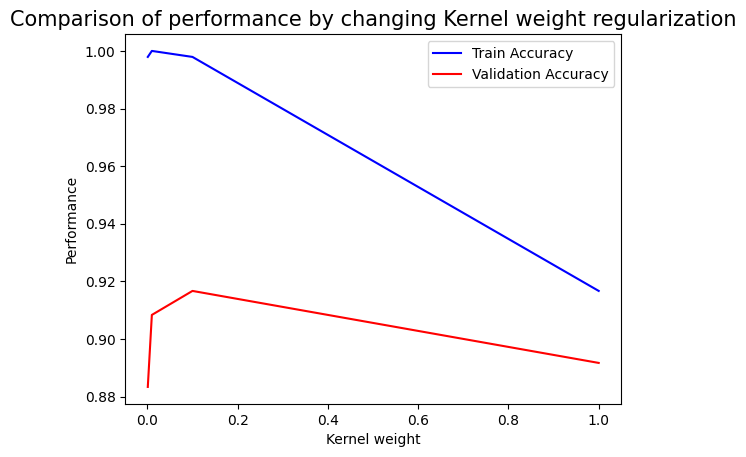

In [ ]:
plt.plot(regularization_params,train_accuracy,color = 'Blue',label='Train Accuracy')
plt.plot(regularization_params,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Kernel weight")
plt.title('Comparison of performance by changing Kernel weight regularization', size=15)
plt.legend()
plt.show()

#4

###Dropout Rate

In [ ]:
no_of_neurons_1 = len(class_names)
dropout_rate=[0.1,0.2,0.3,0.05,0.001,0.004,0.02,0.008]

train_accuracy=[]
val_accuracy=[]
for i in dropout_rate:
  neurons.append(i)
  base_model = tf.keras.applications.MobileNetV2(weights= 'imagenet', input_shape=input_shape, include_top=False,)    # False, do not include the classification layer of the model
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(no_of_neurons_1, activation = 'softmax')(x)    # Add own classififcation layer
  tf.keras.layers.Dropout(i)
  model = tf.keras.Model(inputs, outputs)
  cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]
  model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)
  a=model.evaluate(val_ds)
  b=model.evaluate(train_ds)
  val_accuracy.append(a[1])
  train_accuracy.append(b[1])

8/8 [==============================] - 11s 697ms/step - loss: 1.4055 - accuracy: 0.6062 - val_loss: 1.2029 - val_accuracy: 0.6750
Epoch 2/32
8/8 [==============================] - 8s 848ms/step - loss: 0.5741 - accuracy: 0.8167 - val_loss: 0.4735 - val_accuracy: 0.8167
Epoch 3/32
8/8 [==============================] - 6s 543ms/step - loss: 0.2694 - accuracy: 0.9167 - val_loss: 0.4544 - val_accuracy: 0.8583
Epoch 4/32
8/8 [==============================] - 6s 534ms/step - loss: 0.1475 - accuracy: 0.9458 - val_loss: 0.4738 - val_accuracy: 0.8417
Epoch 5/32
8/8 [==============================] - 7s 550ms/step - loss: 0.1161 - accuracy: 0.9583 - val_loss: 0.4924 - val_accuracy: 0.8583
Epoch 6/32
8/8 [==============================] - 6s 572ms/step - loss: 0.0447 - accuracy: 0.9875 - val_loss: 0.4972 - val_accuracy: 0.8583
Epoch 7/32
8/8 [==============================] - 6s 558ms/step - loss: 0.0235 - accuracy: 0.9958 - val_loss: 0.4995 - val_accuracy: 0.8500
Epoch 8/32
8/8 [==============

In [ ]:
pd.DataFrame({'Dropout rate':dropout_rate,'Train Accuracy': train_accuracy,'Validation Accuracy':val_accuracy})

,Dropout rate,Train Accuracy,Validation Accuracy
0,0.100,0.958333,0.850000
1,0.200,1.000000,0.866667
2,0.300,0.937500,0.858333
3,0.050,0.954167,0.858333
4,0.001,1.000000,0.875000
5,0.004,0.962500,0.891667
6,0.020,0.910417,0.866667
7,0.008,0.943750,0.858333


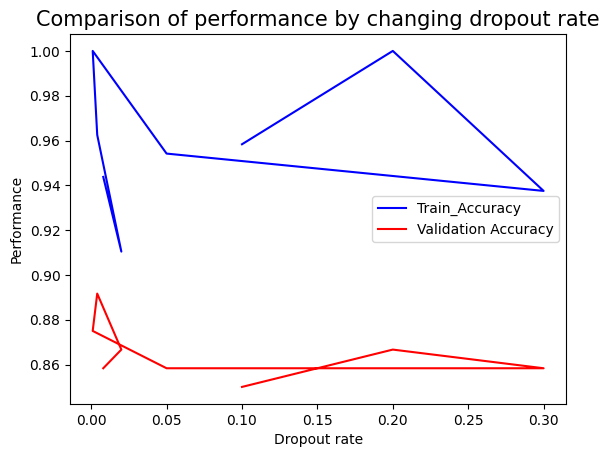

In [ ]:
plt.plot(dropout_rate,train_accuracy,color = 'Blue',label='Train_Accuracy')
plt.plot(dropout_rate,val_accuracy,color = 'Red',label='Validation Accuracy')
plt.ylabel("Performance")
plt.xlabel("Dropout rate")
plt.title('Comparison of performance by changing dropout rate', size=15)
plt.legend()
plt.show()